In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
from tifffile import imread
from scipy.ndimage import gaussian_filter
from scipy.sparse import csr_matrix, isspmatrix
import itertools

In [2]:
adata_exp0 = anndata.read_h5ad('C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/spatial/counts_CPc_exp0_BA28.h5ad')

In [3]:
adata_Yao = anndata.read_h5ad(
    'C:/Users/mdichgan/Documents/Helmholtz/send_to_Jakob/sc/Yao_150kcells_subsample_with_annotations_sparse_subset.h5ad')

In [4]:
adata_Yao.obs["celltype"] = adata_Yao.obs["label"]

In [5]:
adata_exp0.uns["spots"]

,Gene,x,y,celltype,cell
0,Dkk3,512.391380,5606.902438,Ependymal,NaN
1,Neurod6,2821.699052,5717.587559,CA3,1855.0
2,Ipcef1,189.849074,9254.220586,L6 CT CTX,21448.0
3,Bhlhe40,163.399427,9492.570656,L6 CT CTX,NaN
4,Car4,2934.547475,4936.246276,Endo,1464.0
...,...,...,...,...,...
9451287,Cdh13,12888.275625,8106.121692,Oligo,12965.0
9451288,Fign,12322.526209,8205.875478,Oligo,12562.0
9451289,Zfp536,13684.567552,8529.607515,Oligo,20695.0
9451290,Cd24a,13119.715081,8672.515345,Oligo,21389.0


In [6]:
#helper function
def check_crop_exists(x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray):
    """Check if crop coordinates exist.
    
    For this, we check if either (x_min, x_max, y_min, y_max) or an image was provided. If not, we raise a ValueError. 

    Parameters
    ----------
    x_min: int, x_max: int, y_min: int, y_max: int
        crop coordinates
    image: np.ndarray

    Returns
    -------
    if no ValueError was raised, returns range  
    """
    if (x_min is None or x_max is None or y_min is None or y_max is None) and image is None:
        raise ValueError("please provide an image or crop")         
        
    if x_min is not None and x_max is not None and y_min is not None and y_max is not None:
        range = [[x_min,x_max],[y_min,y_max]]
    
    else:
        range = [[0,image.shape[0]],[0,image.shape[1]]]
        
    return range 

In [7]:
#helper function
def matrix_colorbar_plot(matrix: np.ndarray, title: str, x_min: int, x_max: int, y_min: int, y_max: int, smooth: float = 0, show_ticks: bool = False):
    """Display (smoothed and cropped) matrix as an image with a colorbar and title.
    
    Parameters
    ----------
    matrix: np.ndarray
        data
    title: str
    x_min: int, x_max: int, y_min: int, y_max: int
        crop coordinates
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    
    matrix = gaussian_filter(matrix,sigma=smooth)
    fig = plt.figure()
    ax = fig.add_subplot(title = title)
    plot = plt.imshow(matrix, interpolation='nearest', extent=[x_min, x_max, y_max, y_min])
    fig.colorbar(plot)
    
    if not show_ticks:
        ax.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)

In [8]:
def get_negative_marker_dict(adata_sp: AnnData, adata_sc: AnnData, key: str='celltype'):
    """Add dictionary of negative marker genes for different celltypes.
    
    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    key : str
        Celltype key in adata_sp.obs and adata_sc.obs

    Returns
    -------
    neg_marker_dict : dict[string: list]
        Dictionary with celltypes as keys and corresponding negative marker genes as values
    """

    # Set threshold parameters
    min_number_cells=10 # minimum number of cells belonging to a cluster to consider it in the analysis
    max_ratio_cells=0.005 # maximum ratio of cells expressing a marker to call it a negative marker gene-ct pair

    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    # Subset adata_sc to genes of spatial data
    adata_sc = adata_sc[:,adata_sp.var_names]           
    
    adata_sc.layers["raw"] = adata_sc.X

    # TMP fix for sparse matrices, ideally we don't convert, and instead have calculations for sparse/non-sparse
    if isspmatrix(adata_sc.layers["raw"]):                                  
        adata_sc.layers["raw"] = adata_sc.layers["raw"].toarray()

    # Get cell types that we find in both modalities
    shared_celltypes = adata_sc.obs.loc[adata_sc.obs[key].isin(adata_sp.obs[key]),key].unique()
    
    # Filter cell types by minimum number of cells
    celltype_count_sc = adata_sc.obs[key].value_counts().loc[shared_celltypes]
    celltype_count_sp = adata_sc.obs[key].value_counts().loc[shared_celltypes]   
    ct_filter = (celltype_count_sc >= min_number_cells) & (celltype_count_sp >= min_number_cells)
    celltypes = celltype_count_sc.loc[ct_filter].index.tolist()             
    
    
    # Filter cells to eligible cell types
    adata_sc = adata_sc[adata_sc.obs[key].isin(celltypes)]
    genes = adata_sc.var_names
    
    # Get ratio of positive cells per cell type
    pos_exp_sc = pd.DataFrame(adata_sc.layers["raw"] > 0,columns=adata_sp.var_names)     
    pos_exp_sc['celltype'] = list(adata_sc.obs[key])
    ratio_celltype_sc = pos_exp_sc.groupby('celltype').mean()
    
    # Get gene-cell type pairs with negative marker expression
    neg_marker_mask = np.array(ratio_celltype_sc < max_ratio_cells)
    

    neg_marker_mask = pd.DataFrame(neg_marker_mask, columns = genes, index = ratio_celltype_sc.index)   
    neg_marker_dict = {celltype: list(row.index[row]) for celltype, row in neg_marker_mask.iterrows()}

    return neg_marker_dict


In [9]:
#test get_negative_marker_dict
dict_exp0 = get_negative_marker_dict(adata_sp = adata_exp0, adata_sc = adata_Yao, key ='celltype')
len(dict_exp0.keys())

21

In [10]:
def get_neg_mark_read_in_corr_ct(adata_sp: AnnData, adata_sc: AnnData):

    """Add column in_correct_celltype.

       spot_assignment is "spot in wrong celltype", if celltype of cell is in the keys of the neg_marker_dict and gene is a negative marker for the celltype. 
       spot_assignment is "unassigned" if the corresponding cell entry is NaN.
       spot_assignment is "no negative marker" if gene is  not a negative marker for any celltype in neg_marker_dict.
       spot_assignment is "spot in correct celltype" otherwise.
      
       Parameters
       ----------
       adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
       adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data
    
       Returns
       ----------
       modified adata_sp
    """ 
    #check that genes in spatial data is subset of genes in single cell data
    adata_sp = adata_sp[:,adata_sp.var_names.isin(adata_sc.var_names)]

    df = adata_sp.uns["spots"]  
   
    neg_marker_dict = get_negative_marker_dict(adata_sp, adata_sc)

    celltypes = list(neg_marker_dict.keys())   

    df["spot_assignment"] = "spot in correct celltype"

    all_neg_markers = set(itertools.chain(*neg_marker_dict.values()))
    df.loc[(~df["Gene"].isin(all_neg_markers))& (~df["celltype"].isin(celltypes)), "spot_assignment"] = "no negative marker"  
    #gene is not a negative marker for any celltype in neg_marker_dict and celltype is not in celltypes 
    for ct in celltypes:
      df.loc[(df["Gene"].isin(neg_marker_dict[ct])) & (df["celltype"] == ct), 'spot_assignment'] = "spot in wrong celltype" 

    df.loc[df["cell"]!=df["cell"],"spot_assignment"] = "unassigned"   #check for NaNs
    
    return adata_sp

In [11]:
#test get_neg_mark_read_in_corr_ct
get_neg_mark_read_in_corr_ct(adata_sp=adata_exp0, adata_sc=adata_Yao)
df_exp0 = adata_exp0.uns["spots"]
print(df_exp0['x'].min(), df_exp0['x'].max(), df_exp0['y'].min(), df_exp0['y'].max())

12.245943333879998 13779.88508614 23.3559417021 19435.64276574


In [12]:

a = len(df_exp0.loc[df_exp0["spot_assignment"]=="spot in correct celltype"])/len(df_exp0)
b = len(df_exp0.loc[df_exp0["spot_assignment"]=="spot in wrong celltype"])/len(df_exp0)
c = len(df_exp0.loc[df_exp0["spot_assignment"]=="unassigned"])/len(df_exp0)
d = len(df_exp0.loc[df_exp0["spot_assignment"]=="no negative marker"])/len(df_exp0)

In [13]:
print(a,b,c,d)

0.463683166280335 0.01028335596868661 0.4900467576284808 0.03598672012249754


In [14]:
def get_cells_df(adata_sp: AnnData, adata_sc: AnnData):
    """Get cell location DataFrame.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    adata_sc : AnnData
        Annotated ``AnnData`` object with counts scRNAseq data

    Returns
    -------
        adata_sp, where adata_sp.obs has additional columns: x,y
    """
    get_neg_mark_read_in_corr_ct(adata_sp,adata_sc)
    spots = adata_sp.uns["spots"]
    df_cells = spots.loc[spots["spot_assignment"]!="unassigned"]      
    df_cells = df_cells.groupby(["cell"])[["x","y"]].mean()
    df_cells = df_cells.reset_index().rename(columns={'cell':'cell'})
    adata_sp.obs = pd.merge(df_cells,adata_sp.obs,left_on="cell",right_on="cell_id",how="inner")

    return adata_sp

In [15]:
get_cells_df(adata_sp = adata_exp0, adata_sc = adata_Yao)

c:\Users\mdichgan\AppData\Local\miniconda3\envs\txsim\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 23282 × 284
    obs: 'cell', 'x', 'y', 'cell_id', 'ct_majority', 'ct_majority_cert', 'celltype', 'n_counts', 'n_genes', 'area'
    var: 'n_counts', 'n_cells'
    uns: 'log1p', 'pct_noise', 'spots'
    layers: 'lognorm', 'norm', 'raw', 'raw_counts'

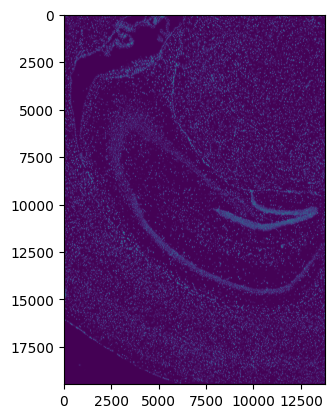

In [16]:
image = imread(r"C:\Users\mdichgan\Documents\Helmholtz\send_to_Jakob\tif_images\background.tiff")
plt.imshow(image)

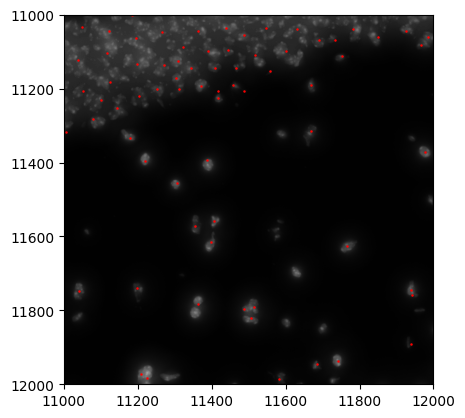

In [122]:
#plot cell nuclei allignment
df = adata_exp0.obs
x_min, x_max, y_max, y_min = 11000, 12000, 12000, 11000

fig, ax = plt.subplots()
ax.axis([x_min, x_max, y_max, y_min])        
ax.imshow(image,cmap = "binary_r") 

#filter spots
df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

ax.scatter(df['x'], df['y'], s = 0.6, color = "red")

In [17]:
def plot_spots(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, show_ticks: bool = False):
    """Plot gene spots.
     
     Spot is red if entry in 'spot_assignment' is "spot in wrong celltype", blue if "spot in correct celltype", grey if "unassigned", green if "no negative marker".

     Parameters
     ----------
     adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
     x_min : int, x_max : int, y_min : int, y_max : int 
          crop coordinates
     image : NDArray
          read from image of dapi stained cell-nuclei
     show_ticks : bool 
          default False, show no ticks or labels
    """

    df = adata_sp.uns["spots"]
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    
    s_factor =  150000/((x_max-x_min)**2)                  

    plt.axis([x_min, x_max, y_max, y_min])        
    plt.imshow(image,cmap = "binary_r") 

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]
    
    
    plt.scatter(df.loc[df['spot_assignment']=="unassigned","x"],df.loc[df['spot_assignment']=="unassigned","y"], s = 0.3*s_factor, color = "grey", label = "unassigned")
    plt.scatter(df.loc[df['spot_assignment']=="spot in correct celltype","x"],df.loc[df['spot_assignment']=="spot in correct celltype","y"], s = 0.5*s_factor, color = "blue", label = "spot in correct celltype")
    plt.scatter(df.loc[df['spot_assignment']=="spot in wrong celltype","x"],df.loc[df['spot_assignment']=="spot in wrong celltype","y"], s = 1*s_factor, color = "red", label = "spot in wrong celltype")
    plt.scatter(df.loc[df['spot_assignment']=="no negative marker","x"],df.loc[df['spot_assignment']=="no negative marker","y"], s = 1*s_factor, color = "green", label = "no negative marker")
    
    lgnd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), scatterpoints=1, markerscale=2)

    #fix size of legend spots 
    lgnd.legend_handles[0]._sizes = [10]
    lgnd.legend_handles[1]._sizes = [10]
    lgnd.legend_handles[2]._sizes = [10]
    lgnd.legend_handles[3]._sizes = [10]

    if not show_ticks:
        plt.tick_params(which='both', bottom=False, left=False, labelbottom = False, labelleft = False)
    

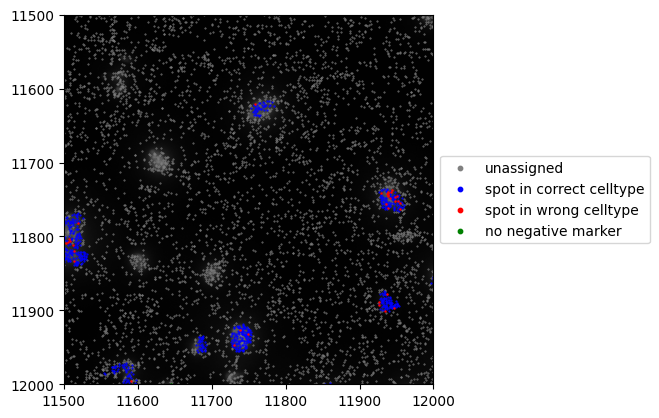

In [18]:
plot_spots(adata_exp0, 11500,12000,11500,12000,image,show_ticks=True)

In [19]:
def get_wrong_spot_ratio(adata_sp : AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get density array of spots in wrong celltype.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of negative marker reads per bin
    range : range of binning 
    """
    df = adata_sp.uns["spots"]
    np.seterr(invalid='ignore')

    range = check_crop_exists(x_min,x_max,y_min,y_max,image)

    true_spots = df.loc[(df['spot_assignment'] == "spot in correct celltype") | (df['spot_assignment'] == "no negative marker")]
    H_t = np.histogram2d(true_spots['x'], true_spots['y'], bins, range)[0].T

    spots_in_wrong_ct = df.loc[df['spot_assignment'] == "spot in wrong celltype"]
    H_w = np.histogram2d(spots_in_wrong_ct['x'], spots_in_wrong_ct['y'], bins, range)[0].T

    H = H_w/(H_t+H_w)       #ignore "Unassigned" spots in density calculation, since it could be both assigned correctly or wrongly
    H[np.isnan(H)] = 0      #no negative marker wrongly assigned where no spots

 
    return H,range
    

In [20]:
A,r = get_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 20)

In [21]:
def plot_wrong_spot_ratio(adata_sp : AnnData, x_min: int, x_max: int, y_min: int, y_max: int,
                       image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False): 
    """Plot density of spots in wrong celltype.

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_wrong_spot_ratio(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    title = "spots in wrong celltype density"
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)



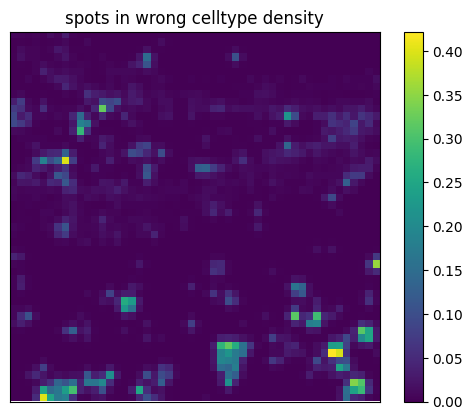

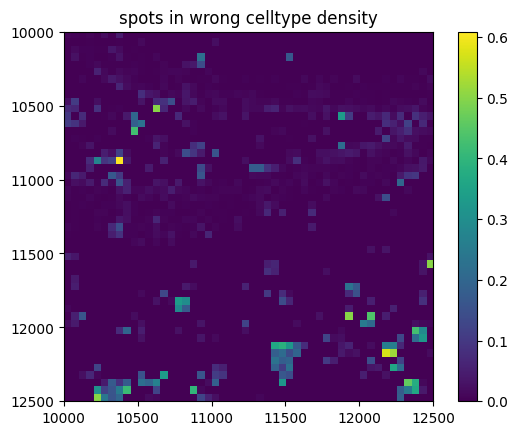

In [22]:
plot_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 50, smooth=0.5)
plot_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 50, show_ticks=True)

In [23]:
def get_spot_density(adata_sp : AnnData, spot_types: list['str'], x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get density of specified spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker")

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    spot_types: list['str']
        specify, which spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker") should be included in calculation
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of specified spottypes reads per bin
    range : range of binning 
    """
    df = adata_sp.uns["spots"]

    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    spots = df.loc[df['spot_assignment'].isin(spot_types)]          
    H = np.histogram2d(spots['x'], spots['y'], bins, range)[0].T

    return H, range


In [ ]:
get_spot_density(adata_exp0,["spot in wrong celltype", "spot in correct celltype"],10000,12500,10000,12500,image=None,bins = 20)


In [25]:
def plot_spot_density(adata_sp : AnnData, spot_types: list, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot density of specified spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker").

    Parameters
    ----------
    adata_sp : AnnData
        Annotated ``AnnData`` object with counts from spatial data
    spot_types: list[str]                    
        specify, which spot types ("spot in wrong celltype", "spot in correct celltype", "unassigned", "no negative marker") should be included in calculation
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    matrix, range = get_spot_density(adata_sp,spot_types,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    spot_types_str = '-/'.join([f"'{spot}'" for spot in spot_types])
    title = f"density of {spot_types_str} spots"        #schöner machen
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)

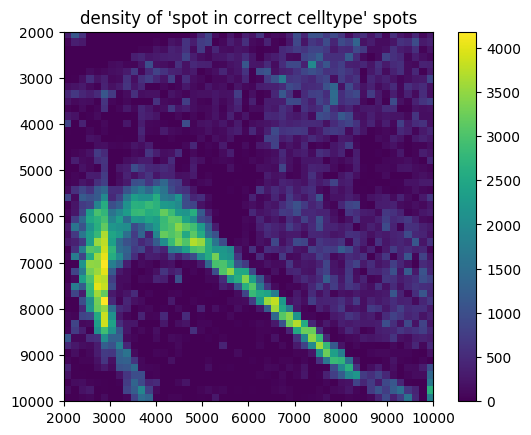

In [26]:
plot_spot_density(adata_exp0,["spot in correct celltype"],2000,10000,2000,10000,image=None,bins = 50, show_ticks=True)

In [28]:
def get_cell_density(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get cell density.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of cells per bin
    range : range of binning 
    """
     
    df_cells = adata_sp.obs 
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    H = np.histogram2d(df_cells['x'], df_cells['y'], bins, range)[0].T

    return H, range

In [ ]:
get_cell_density(adata_exp0,10000,12500,10000,12500,image=None,bins = 20)

In [30]:
def plot_cell_density(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot cell density.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_cell_density(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "cell density"
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)

    

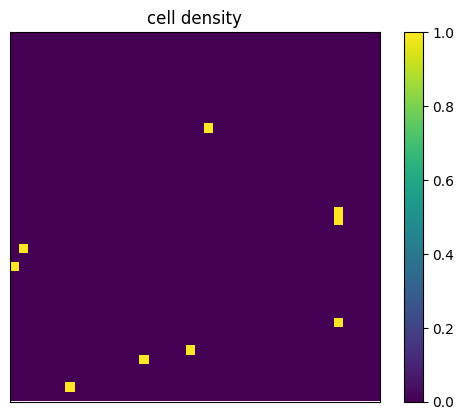

In [31]:
plot_cell_density(adata_exp0,11500,12000,11500,12000,image=None,bins = 40)

In [32]:
def get_celltype_density(adata_sp: AnnData, celltype: str, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get celltype density.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    celltypes : str
        celltype
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    Returns
    -------
    H : array of floats
        density of celltype per bin
    range : range of binning 
    """
    df =  adata_sp.obs
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    H_total = np.histogram2d(df['x'],df['y'], bins, range)[0]

    df = df.loc[df["celltype"]==celltype]

    H_celltype = np.histogram2d(df['x'],df['y'], bins, range)[0]

    H = H_celltype/H_total
    H[np.isnan(H)] = 0     #0 cells therefore also 0% celltype in the respective area
    H = H.T

    
    # df = adata_sp.obs
    # bin_range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    # H_total = np.histogram2d(df['x'],df['y'], bins, bin_range)[0]
    # #Annahme: bins: [int,int]
    # #TODO: fix bin options
    # number_of_celltypes = len(celltypes)
    # H_celltypes = np.zeros((number_of_celltypes,bins[0], bins[1]))

    # for i in range(number_of_celltypes):
    #     df_t = df.loc[df["celltype"]==celltypes[i]]
    #     H_celltypes[i,...] = np.histogram2d(df_t['x'],df_t['y'], bins, bin_range)[0]
    #     H_celltypes[i,...] =  H_celltypes[i,...]/H_total
    #     H_celltypes[i,...][np.isnan(H_celltypes[i,...])] = 0

    # H_celltypes.transpose((0,2,1))
    
    return H, range

In [ ]:
get_celltype_density(adata_exp0,"CA3", 10000,12500,10000,12500,image=None,bins = [10,20])[0]

In [34]:
def plot_celltype_density(adata_sp: AnnData, celltypes: list, x_min: int, x_max: int, y_min: int, y_max: int,
                      image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot cell density

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    celltypes : list[str]
        list of celltypes
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : int or array_like or [int, int] or [array, array]
        The bin specification:
        If int, the number of bins for the two dimensions (nx=ny=bins).
        If array_like, the bin edges for the two dimensions (x_edges=y_edges=bins).
        If [int, int], the number of bins in each dimension (nx, ny = bins).
        If [array, array], the bin edges in each dimension (x_edges, y_edges = bins).
        A combination [int, array] or [array, int], where int is the number of bins and array is the bin edges.
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    number_of_celltypes = len(celltypes)
    
    for i in range(number_of_celltypes):
        matrix, range_ = get_celltype_density(adata_sp,celltypes[i],x_min,x_max,y_min,y_max,image,bins)
        x_min, x_max, y_min, y_max = np.ravel(range_).tolist()
        title = f"{celltypes[i]} density"
        matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)
    

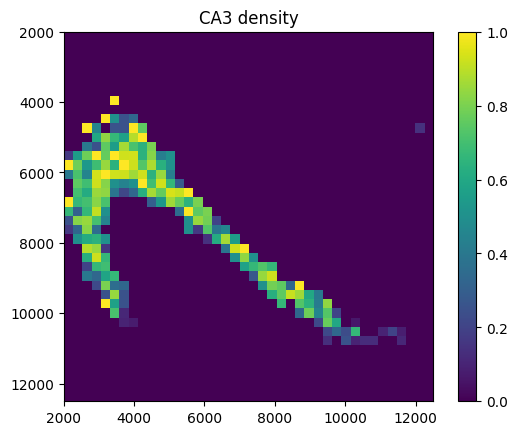

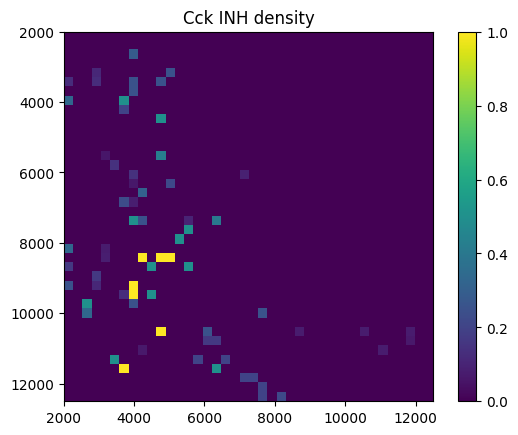

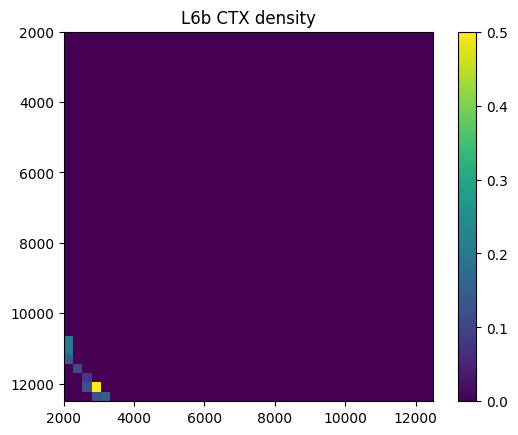

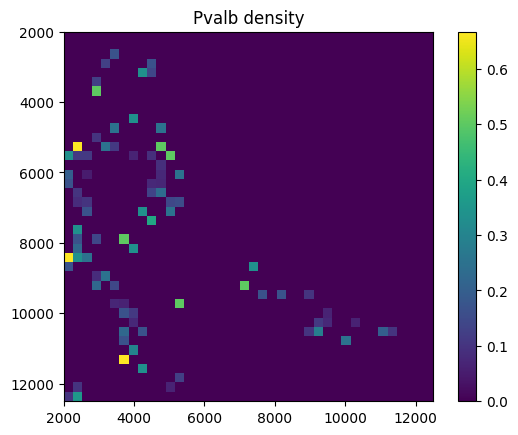

In [35]:
plot_celltype_density(adata_exp0,["CA3","Cck INH","L6b CTX","Pvalb"], 2000,12500,2000,12500,image=None,bins = [40,40],show_ticks=True)

In [ ]:
a = np.zeros((2,2,3))
a[0,...] = np.array([[1.0,1,1],[1,1,1]])
a[1,...] = np.array([[0,1,0],[2,0,3]])
print(a)
b = np.max(a, axis = 0)
print(b)
c = np.argmax(a,axis=0)
print(c)
print(np.dtype(c[1,0]))
z = ['a','b']

result = np.take(z,c)
print(result)

In [36]:
def get_number_of_celltypes(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get number of celltypes
    
    Parameters
    ---------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        number of celltypes per bin
    range : range of binning 
    """
    #? celltypes auswählen

    range_ = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    celltypes = adata_sp.obs["celltype"].unique()  
    A = np.zeros((len(celltypes),bins[0],bins[1]))   

    for i in range(len(celltypes)):
        A[i,...] = get_celltype_density(adata_sp, celltypes[i],x_min,x_max,y_min,y_max,image,bins)[0]
    A = sum(A>0)
    
    return A, range_

In [ ]:
get_number_of_celltypes(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

In [38]:
def plot_number_of_celltypes(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):    
    """Plot number of celltypes
    
    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    matrix, range = get_number_of_celltypes(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()
    
    title = "number of celltypes"
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)

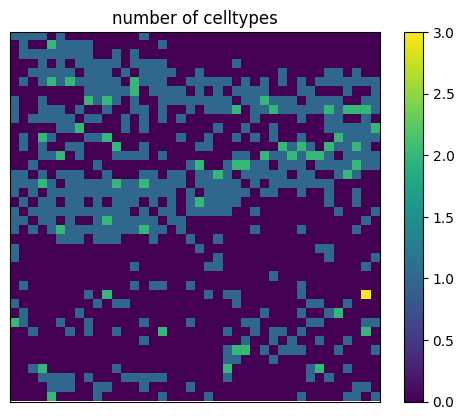

In [39]:
plot_number_of_celltypes(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40])

In [40]:
def get_major_celltype_perc(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get major celltype percentage.
    
    Parameters
    ---------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        major celltype percentage
    range : range of binning 
    """
    range_ = check_crop_exists(x_min,x_max,y_min,y_max,image)
    
    celltypes = adata_sp.obs["celltype"].unique()
    A = np.zeros((len(celltypes),bins[0],bins[1]))   
    # B = np.zeros((2,bins[0],bins[1]))
    
    for i in range(len(celltypes)):
        A[i,...] = get_celltype_density(adata_sp, celltypes[i],x_min,x_max,y_min,y_max,image,bins)[0]
    B = np.max(A,axis=0)

    # B[1,...] = np.argmax(A,axis = 0)
    # B[1,...] = np.take(celltypes,B[1,...])

    return B, range_

In [ ]:
get_major_celltype_perc(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

In [42]:
def plot_major_celltype_perc(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):    
    """Plot major celltype percentage.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """
    
    matrix, range = get_major_celltype_perc(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "major celltype percentage"
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)

    

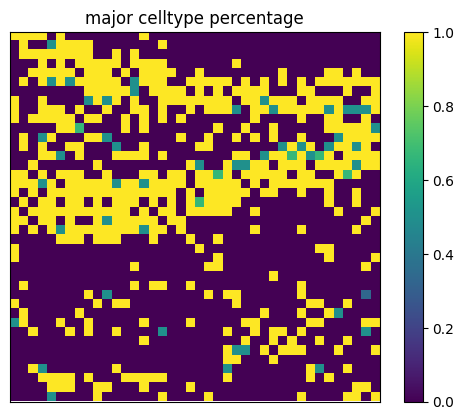

In [43]:
plot_major_celltype_perc(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40])

In [49]:
def get_summed_cell_area(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins):
    """Get summed cell area.
    
    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    Returns
    -------
    H : array of floats
        summed cell area
    range : range of binning 
    """
    df = adata_sp.obs
    range = check_crop_exists(x_min,x_max,y_min,y_max,image)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    #filter spots
    df = df.loc[(df['x']>= x_min) & (df['x']<=x_max) & (df['y']>=y_min) & (df['y']<=y_max)]

    bins_x = np.digitize(df['x'], np.linspace(x_min, x_max, bins[0] + 1)) -1
    bins_y = np.digitize(df['y'], np.linspace(y_min, y_max, bins[1] + 1)) -1

    groups = df.groupby([bins_x, bins_y])
    sums = groups['area'].sum()
    summed_cell_area = np.zeros((bins[0],bins[1]))

    for (i,j), value in sums.items():
        summed_cell_area[i,j] = value
    
    return summed_cell_area.T, range

In [ ]:
get_summed_cell_area(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

In [46]:
def plot_summed_cell_area(adata_sp: AnnData, x_min: int, x_max: int, y_min: int, y_max: int, image: np.ndarray, bins, smooth: float = 0, show_ticks: bool = False):
    """Plot summed cell area.

    Parameters
    ----------
    adata_sp: AnnData
        Annotated ``AnnData`` object with counts from spatial data
    x_min : int, x_max : int, y_min : int, y_max : int 
        crop coordinates
    image : NDArray
        read from image of dapi stained cell-nuclei
    bins : [int,int]
        the number of bins in each dimension
    smooth : float = 0
        sigma parameter of scipy.ndimage.gaussian_filter function
    show_ticks : bool 
        default False, show no ticks or labels
    """

    matrix, range = get_summed_cell_area(adata_sp,x_min,x_max,y_min,y_max,image,bins)
    x_min, x_max, y_min, y_max = np.ravel(range).tolist()

    title = "summed cell area"
    matrix_colorbar_plot(matrix, title, x_min, x_max, y_min, y_max, smooth, show_ticks)

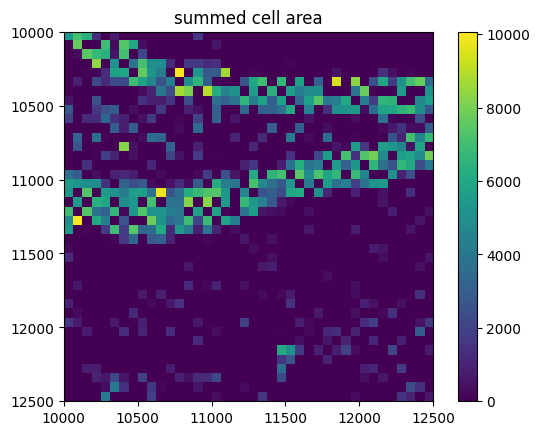

In [50]:
plot_summed_cell_area(adata_exp0,10000,12500,10000,12500,image=None,bins = [40,40], show_ticks=True)

In [54]:
def get_correlate_mats(mat_1: np.ndarray, mat_2: np.ndarray):
    """Compute the Pearson correlation coefficients between flattened mat_1 and mat_2.
       
    Parameters
    ----------
    mat_1: np.ndarray
        first matrix
    mat_2: np.ndarray
        second matrix
    Returns
    -------
    corr_coeff : float   
    """
    mat_1 = mat_1.flatten()
    mat_2 = mat_2.flatten()

    corr_coeff = np.corrcoef(mat_1,mat_2)[0,1]
    
    return corr_coeff

In [52]:
M_wrong_spot_density = get_wrong_spot_ratio(adata_exp0,10000,12500,10000,12500,image=None,bins = 20)[0]
M_spot_density = get_spot_density(adata_exp0,["spot in wrong celltype"],10000,12500,10000,12500,image=None,bins = 20)[0]
M_cell_density = get_cell_density(adata_exp0,10000,12500,10000,12500,image=None,bins = 20)[0]
M_celltype_density = get_celltype_density(adata_exp0,"CA3", 10000,12500,10000,12500,image=None,bins = [20,20])[0]
M_number_of_celltypes = get_number_of_celltypes(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]
M_major_celltype_perc = get_major_celltype_perc(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]
M_summed_cell_area = get_summed_cell_area(adata_exp0,10000,12500,10000,12500,image=None,bins = [20,20])[0]

In [55]:
measurements = [M_wrong_spot_density,M_spot_density,M_cell_density,M_celltype_density,M_number_of_celltypes,M_major_celltype_perc,M_summed_cell_area]
n = len(measurements)
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        A[i,j] = get_correlate_mats(measurements[i],measurements[j])

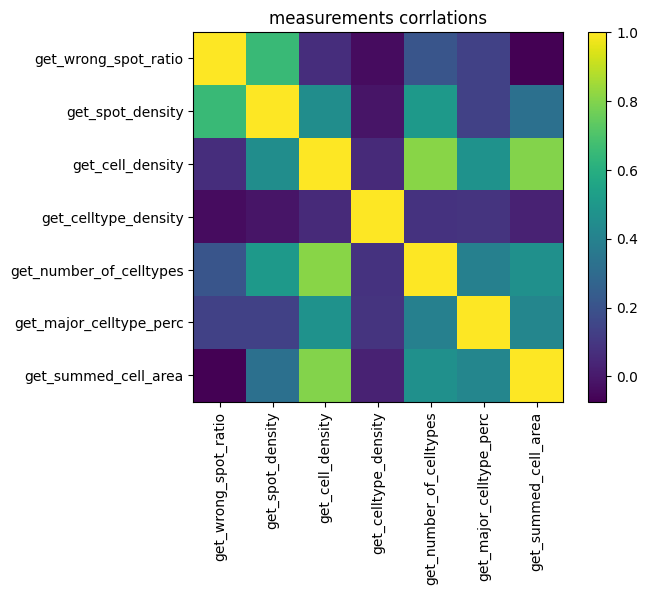

In [56]:
fig,ax = plt.subplots()
ax.set_title("measurements corrlations")
plot = plt.imshow(A)
ax.set_xticks([0,1,2,3,4,5,6],["get_wrong_spot_ratio","get_spot_density","get_cell_density",
               "get_celltype_density","get_number_of_celltypes","get_major_celltype_perc","get_summed_cell_area"])
plt.xticks(rotation = 90)
ax.set_yticks([0,1,2,3,4,5,6],["get_wrong_spot_ratio","get_spot_density","get_cell_density",
               "get_celltype_density","get_number_of_celltypes","get_major_celltype_perc","get_summed_cell_area"])
fig.colorbar(plot)    
        